# 0. Import our libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression


# 1. Import data


In [3]:
# code here
data_path = "data/medical_insurance.csv"
try:
    df = pd.read_csv(data_path)
    display(df.head())
except FileNotFoundError:
    print("Error: File not found")
except Exception as e:
    print(f"An error occurred: {e}")

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 2. Helper Functions


In [29]:
def hist_plot(feature, title: str, color: str, x_label: str = None, y_label : str = None):
    # Histograms for numerical variables
    plt.hist(feature, color=color, edgecolor= 'black')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def bar_plot(feature, title: str, color: str):
    # Bar plots for categorical variables
    feature.value_counts().plot(kind = 'bar', color=color)
    plt.title(title)
    plt.show()



# 3. Exploratory Data Analysis (EDA)
- How many rows and how many columns?  
- What is the meaning of each row?  
- Are there **<span style="color:red">duplicated rows</span>**?  
- What is the meaning of each column?  
- What is the current data type of each column? Are there columns having **<span style="color:red">inappropriate data types</span>**?  
- With each numerical column, how are values distributed?  
  - What is the percentage of **<span style="color:red">missing values</span>**?  
  - Min? max? Are they **<span style="color:red">abnormal</span>**?  
- With each categorical column, how are values distributed?  
  - What is the percentage of **<span style="color:red">missing values</span>**?  
  - How many different values? Show a few  
  - Are they **<span style="color:red">abnormal</span>**?

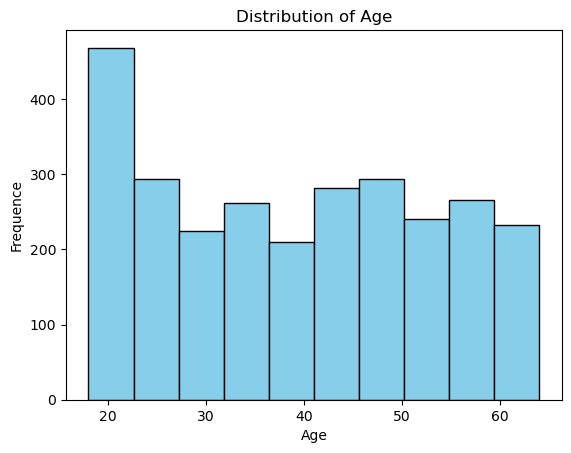

In [27]:
hist_plot(df["age"], "Distribution of Age", 'skyblue', "Age", "Frequence")

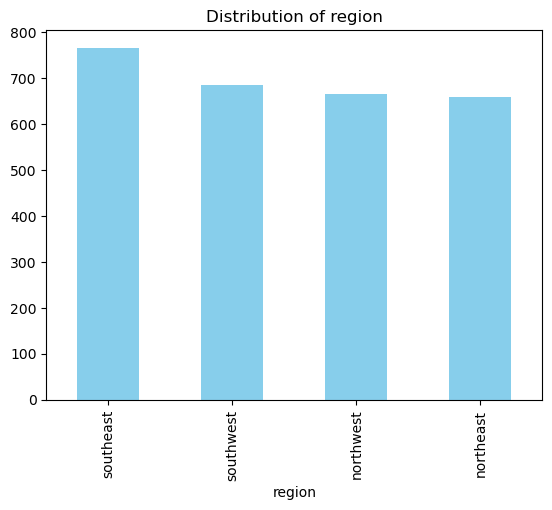

In [25]:
bar_plot(df["region"], "Distribution of region", "skyblue")

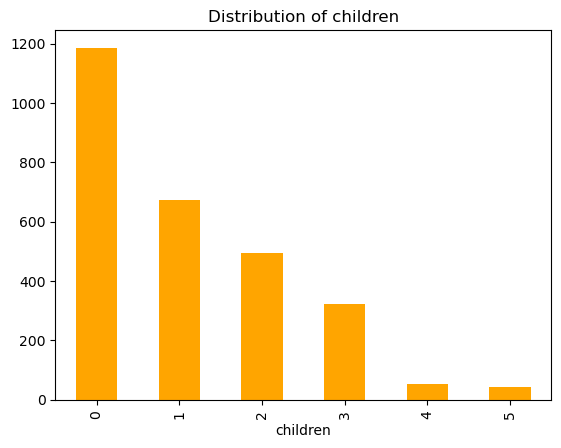

In [31]:
bar_plot(df["children"], "Distribution of children", "orange")

# 4. Building models


# 5. Evaluate 

# 6. Reflection
- **Each member:** What difficulties have you encountered?  
- **Each member:** What have you learned?  
- **Your group:** If you had more time, what would you do?


# 7. References
- To finish this project, what materials have you consulted